# <center>MEFE 2023: TP Computacional 1</center>
Estudiante: $\mathcal{A}\text{gustín} \:\mathcal{B}\text{rusco}$

Archivo complementario: [`MEFE/Codigo/utils.py`](https://github.com/agustinbrusco/MEFE/blob/master/Codigo/utils.py)

In [1]:
# Importo librerías y defino formato de gráficos
import numpy as np
from scipy.stats import binom, poisson
# ⬇ https://github.com/agustinbrusco/MEFE/blob/master/Codigo/utils.py
from utils import RNG, simular_experimentos_bernoulli, plot_discrete_hist, plot_discrete_stem

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # Para gráficos de alta resolución
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['legend.fontsize'] = "medium"
plt.rcParams['axes.labelsize'] = 'large'

## 1. Generar Variables de Distribución Uniforme
En Python puede usarse la función `random(n)` de numpy para generar `n` números aleatorios en el intervalo $[0, 1)$ distribuidos uniformemente. Así, para mostar que "la probabilidad de obtener un número en el intervalo $[0, p)$" es $p$, puede observarse en una muestra suficientemente grande que aproximadamente $p \cdot n$ de ellos pertenezcan a dicho intervalo (es decir, una fracción $\sim p$ de la muestra pertenece al intervalo). Así, una posible demostración computacional de esta propiedad podría consistir del siguiente experimento:
* Generar $n$ números aleatorios en el intervalo $[0, 1)$ mediante la función `random`.
* Para distintos valores de $p$, contar qué fracción ($f_\mathrm{obs}$) de los $n$ valores generados pertenece al intervalo $[0, p)$ (equivalentemente, la fracción de los valores que es menor a $p$).
* Verificar que la diferencia entre $f_\mathrm{obs}$ y $p$ disminuye para todo $p$ a medida que $n$ aumenta.

Si bien queda demostrado por ser el caso complementario, el mismo experimento puede realizarse para mostrar que la probalidad de que el número pertenezca al intervalo $[p, 1)$ es de $1 - p$.

En las siguientes celdas se lleva a cabo dicho experimento para $\ n \in \{10,\ 14,\ 22,\ \dots,\ 1.000.000\}\ $ y $\ p \in \{0, 0,\!01, 0,\!02, \dots, 0,\!99, 1\}\ $.

In [2]:
# Cálculo de las fracciones de valores aleatorios menores que p para distintos tamaños de muestra
size_vals = np.geomspace(10, 1e6, 30, dtype=int)  # 10, 14, 22, ..., 1_000_000
prob_vals = np.linspace(0, 1, 101)  # 0, 0.01, 0.02, ..., 0.99, 1
frac_vals = np.empty((size_vals.size, prob_vals.size))  # Tantas filas como tamaños y tantas columnas como probabilidades
for i, sample_size in enumerate(size_vals):
    random_vals = RNG.random(sample_size)
    # Optimizando: Repito para comparar con todas las probabilidades a la vez
    random_array = random_vals.repeat(prob_vals.size).reshape(-1, prob_vals.size)
    frac_vals[i, :] = np.sum(random_array < prob_vals, axis=0) / sample_size    

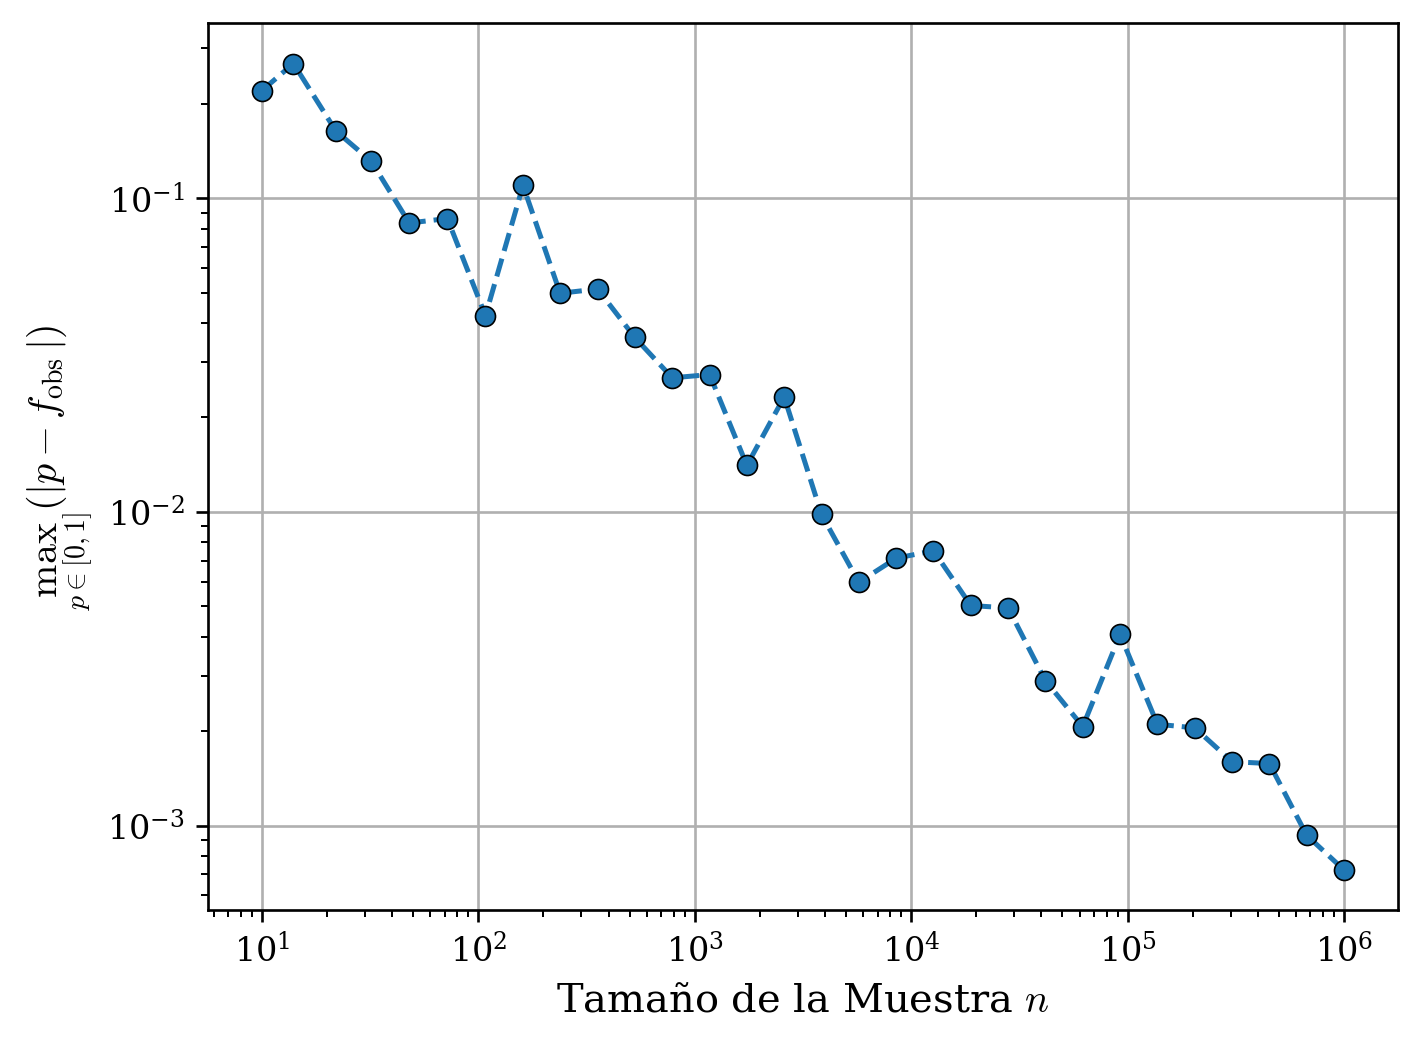

In [3]:
# Máxima diferencia absoluta entre p y f_obs para cada tamaño de muestra
fig, ax = plt.subplots(1, 1)
abs_dif_vals = np.abs(prob_vals - frac_vals)
ax.plot(
    size_vals,
    abs_dif_vals.max(axis=1),
    "o--",
    mec="k",
    mew=0.5,
)
ax.grid()
ax.set_xlabel("Tamaño de la Muestra $n$")
ax.set_ylabel(r"$\max_{p\in[0, 1]}(|p - f_\mathrm{obs}|)$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

De la Figura anterior se puede notar que a medida que aumenta el tamaño de la muestra la tendencia es que el valor absoluto de la diferencia entre $p$ y la frecuencia observada disminuye para todos los valores de $p$ (ya que se observa que el máximo valor de esta diferencia se achica). Así, puede concluirse que la probabilidad de que un número aleatorio generado por `random()` pertenezca al intervalo $[0, p)$ resulta, a efectos prácticos, $p$.

---
Lo siguiente es un ejemplo de una implementación para simular experimentos de Bernoulli: (la definición que utilicé se encuentra en [`utils.py`](https://github.com/agustinbrusco/MEFE/blob/master/Codigo/utils.py))

```python
def simular_experimentos_bernoulli(
    n_experimentos: int,
    p_exito: float,
)-> n_exitos: int:
    """Simula n experimentos de Bernoulli y devuelve el número total de éxitos."""
    resultados = random(n_experimentos) < p_exito
    n_exitos = sum(resultados)  # Recordando que al sumar True "vale 1" y False "vale 0"
    return n_exitos
```

## 2. Simular Detecciones
A continuación se realiza la simulación para un experimento en particular en el que $15$ fotones inciden sobre un detector de eficiencia $\epsilon = 75\%$. En este caso, para cada fotón que incide sobre el detector existen dos posbiles resultados: detección del mismo (con probabilidad $\epsilon$) o este atraviesa el sensor sin ser detectado (con probabilidad $1\!-\!\epsilon$); siendo que el resultado para cada fotón es independiente del resultado de los otros $14$. Así expresado, dados los $15$ fotones que inciden, el problema puede modelarse como si se trata de $15$ experimentos de Bernoulli con probabilidad de éxito $\epsilon$. Luego, la cantidad de fotones detectados en el experimento es la suma de los resultados de los $15$ experimentos de Bernoulli, valor que puede obtenerse utilizando la función definida en el punto anterior.

In [4]:
# Simulación de un experimento:
n_particulas = 15
eficiencia = 0.75
un_experimento = simular_experimentos_bernoulli(n_particulas, eficiencia)
print(
    f"En un experimento incidieron {n_particulas} particulas sobre un detector con eficiencia del {eficiencia:.0%}.",
    f"Esto resultó en {un_experimento} detecciones."
)

En un experimento incidieron 15 particulas sobre un detector con eficiencia del 75%. Esto resultó en 13 detecciones.


A continuación, se repite el experimento $1.000$ veces y se cuenta el número de detecciones asociado a cada realización del experimento. Luego, contando el número de veces que ocurrió cada posible resultado del experimento (desde $0$ detecciones en el "peor caso" hasta $15$ detecciones en el caso en que todos los fotones fueron detectados por el sensor), se obtiene un histograma de ocurrencias por valor observado. Luego, diviendo el número de cuentas en cada _bin_ por los $1.000$ experimentos realizados, se obtiene el histograma de frecuencias observadas que se muestra en la siguiente Figura.

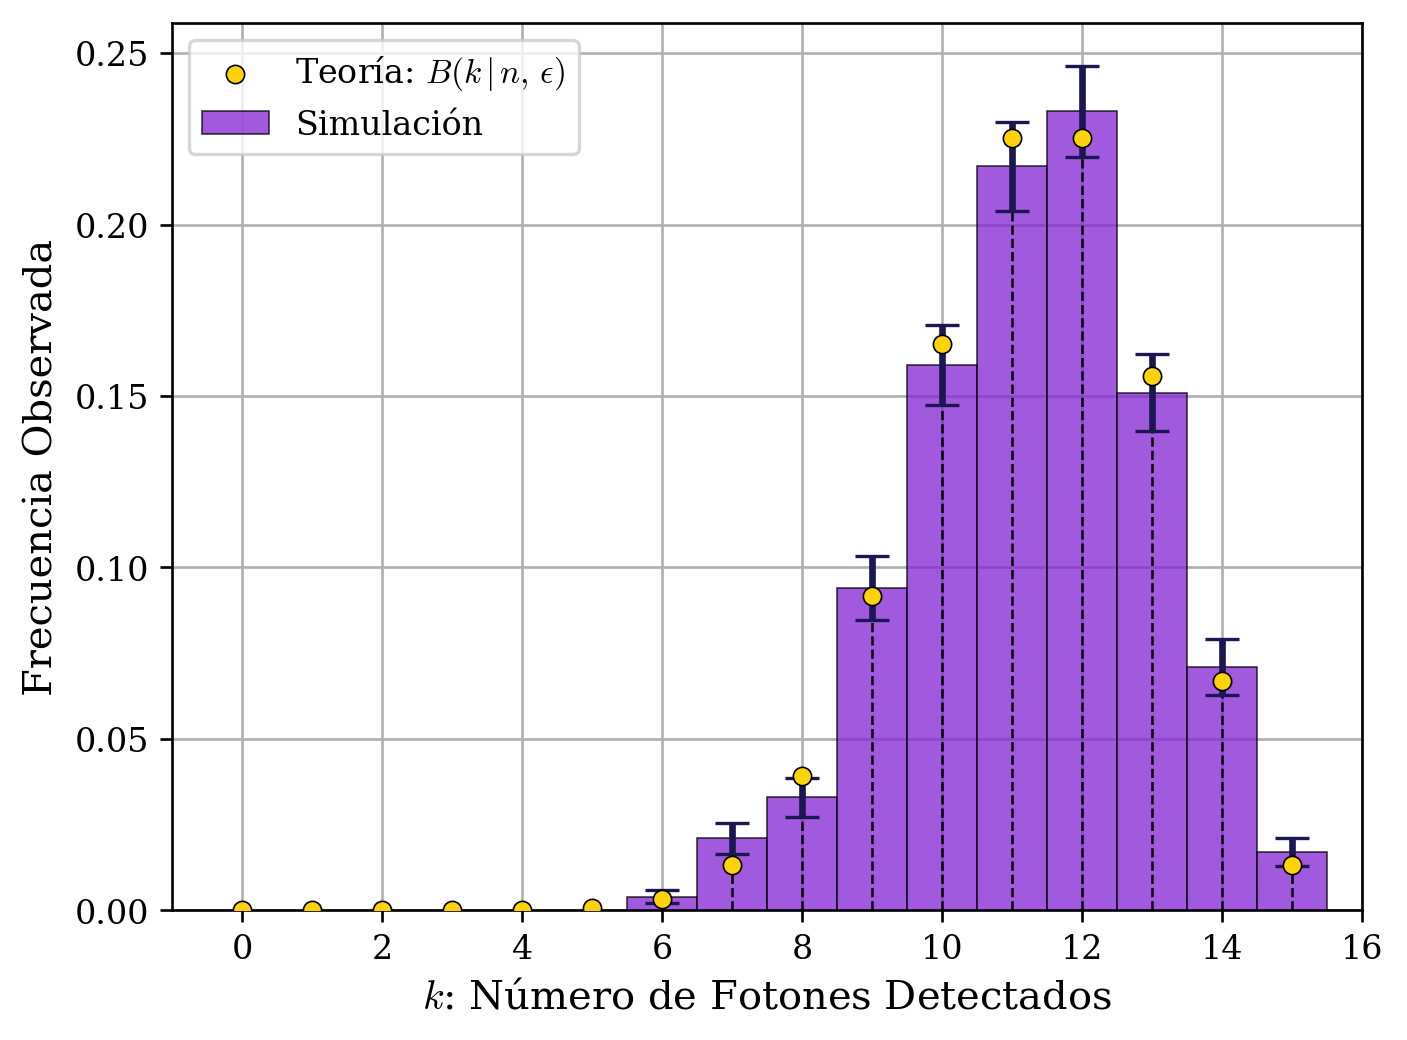

In [5]:
# Simulación de los 1_000 experimentos:
N_experimentos = 1_000
detecciones_por_experimento = np.empty(N_experimentos, dtype=int)
for experimento in range(N_experimentos):
    detecciones_por_experimento[experimento] = simular_experimentos_bernoulli(
        n_particulas, eficiencia
    )
# Calculo de la distribución teorica para dicho proceso:
posibles_resultados = np.arange(n_particulas + 1)
distribucion_esperada = binom.pmf(posibles_resultados, n_particulas, eficiencia)
# Grafico de los resultados:
fig, ax = plt.subplots(1, 1)
plot_discrete_hist(
    detecciones_por_experimento,
    label=f"Simulación",
    zorder=10,
    ax=ax,
)
plot_discrete_stem(
    posibles_resultados,
    distribucion_esperada,
    label=r"Teoría: $B\left(k\,|\,n,\,\epsilon\right)$",
    marker="o",
    zorder=11,
    ax=ax,
)
ax.grid()
ax.legend(loc="upper left")
ax.set_xlabel("$k$: Número de Fotones Detectados")
ax.set_ylabel("Frecuencia Observada")
ax.set_xlim(-1, n_particulas + 1)
plt.show()

Como se observa en la Figura, el histograma de las frecuencias observadas en la simulación coincide a grandes rasgos con las probabilidades dadas por la distribución binomial de $n = 15$ y $p = 0,\!75$ (puntos amarillos): $$B\left(k\:|\:n\!=\!15,\:p\!=\!\epsilon\!=\!0,\!75\right) = \binom{15}{k} (0,\!75)^{k} (0,\!25)^{15-k}$$ la cual es el restulado teórico para la probabilidad de obtener $k$ detecciones en $n$ experimentos de Bernoulli con probabilidad de éxito $p$.

## 3. Emisiones por Segundo
Se busca simular una fuente de luz que emite fotones con intensidad media $I = 15\:\mathrm{s}^{-1}$ durante $\Delta t = 1\:\mathrm{s}$ y calcular el número de fotones emitidos. Para lograr esto, es posible considerar $m = 1.000$ intervalos de duración $\mathrm{d}t = 1\:\mathrm{ms}$ de forma que en cada uno de ellos se aproxima la probabilidad de que sea emitido un fotón como $I\cdot\mathrm{d}t = 1,\!5\%$. Al hacer esto estamos suponiendo que la emisión de cada fotón es independiente de la de los demás de forma que la probabilidad de que sean emitidos dos o más fotones en un intervalo de duración $\mathrm{d}t$ resulta despreciable. Una intuición que acompaña este hecho resulta de pensar que, siendo eventos independientes, su distribución _en el tiempo_ debería ser uniforme (sin intervalos privilegiados); y dado que se esperan observar aproximadamente $15$ fotones a lo largo de un segundo entero, sería muy extraño observar $2$ o más fotones en un intervalo de duración $\mathrm{d}t = 1\:\mathrm{ms}$.

Así planteado, el experimento de duración $\Delta t$ puede pensarse como una sucesión de $m$ experimentos de Bernoulli de duración $\mathrm{d}t$ y probabilidad de éxito $p = 1,\!5\%$ (ya que como máximo esperariamos que se emita un fotón en cada uno de ellos). Luego, el número de fotones emitidos en el experimento largo puede calcularse como la suma de los resultados de los $m$ experimentos de Bernoulli, valor que puede obtenerse utilizando la función definida en el primer punto.

In [6]:
# Simulación de un experimento:
intensidad_media = 15  # s⁻¹
duracion_experimento = 1  # s
subdivisiones = 1_000
intervalos = np.linspace(0, duracion_experimento, subdivisiones+1)  # s
dt = np.diff(intervalos)[0]  # s
probabilidad_de_emision = intensidad_media * dt
fotones_emitidos = simular_experimentos_bernoulli(subdivisiones, probabilidad_de_emision)
print(f"En un experimento de {duracion_experimento} segundo se observaron {fotones_emitidos} fotones.")

En un experimento de 1 segundo se observaron 14 fotones.


En base a este modelo y metodología de simulación, resulta claro que el número fotones emitidos por segundo debe seguir una distribución binomial con $n = 1.000\:$ y $\:p = 1,\!5\%$ (de forma análoga al punto 2). A la vez, el modelo físico de emisión de fotones es consistente con un proceso de Poisson con $\mu = I\!\cdot\!\Delta t = 15$: $$P_{oisson}\left(k\:|\:\mu\!=\!I\!\cdot\!\Delta{t}\!=\!15\right) = \frac{15^{k}}{k!}e^{-15}$$ dado que se están contando eventos de muy baja probabilidad pero frecuencia media constante en el tiempo.

Teniendo dos modelos teóricos que predicen el mismo fenómeno, resulta de interés compararlos con los resultados de la simulación. En la siguiente Figura se muestran superpuestos el histograma de frecuencias observadas al simular $1.000$ realizaciones del experimento de duración $\Delta t$ y las distribuciones de Poisson y binomial mencionadas previamente.

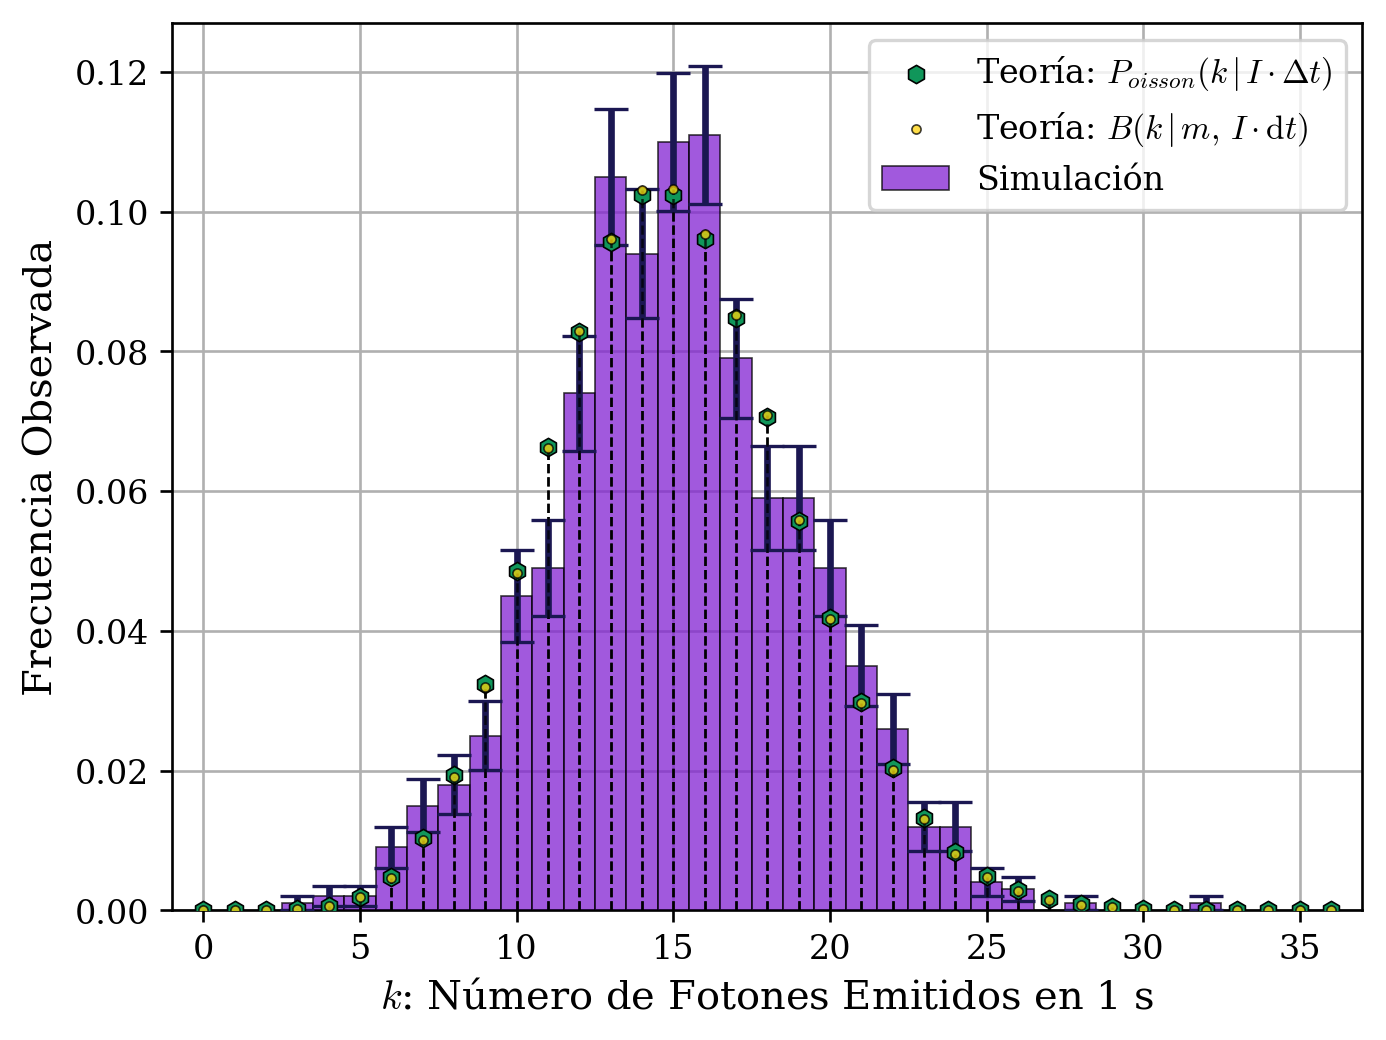

In [7]:
# Simulación de los 1_000 experimentos:
N_experimentos = 1_000
emitidos_por_segundo = np.empty(N_experimentos, dtype=int)
for experimento in range(N_experimentos):
    emitidos_por_segundo[experimento] = simular_experimentos_bernoulli(
        subdivisiones, probabilidad_de_emision
    )
# Cálculo de la distribución teorica de Poisson para dicho proceso:
valores_a_evaluar = np.arange(emitidos_por_segundo.max() + 5)
poisson_esperada = poisson.pmf(
    valores_a_evaluar, duracion_experimento * intensidad_media
)
# Cálculo de la distribución teorica binomial para dicho proceso:
binomial_esperada = binom.pmf(
    valores_a_evaluar, subdivisiones, probabilidad_de_emision
)
# Grafico de los resultados:
fig, ax = plt.subplots(1, 1)
plot_discrete_hist(
    emitidos_por_segundo,
    label="Simulación",
    zorder=10,
    ax=ax,
)
plot_discrete_stem(
    valores_a_evaluar,
    poisson_esperada,
    label=r"Teoría: $P_{oisson}\left(k\,|\,I\cdot\Delta{t}\right)$",
    color="#10965a",
    zorder=11,
    ax=ax,
)
plot_discrete_stem(
    valores_a_evaluar,
    binomial_esperada,
    label=r"Teoría: $B\left(k\,|\,m,\,I\cdot\mathrm{d}t\right)$",
    marker=".",
    alpha=0.75,
    zorder=15,
    ax=ax,
)
ax.grid()
ax.legend()
ax.set_xlabel(f"$k$: Número de Fotones Emitidos en {duracion_experimento} s")
ax.set_ylabel("Frecuencia Observada")
ax.set_xlim(-1, valores_a_evaluar.max() + 1)
plt.show()

En primer lugar, en la Figura se observa que las frecuencia observadas de la simulación no se solapan con los puntos de las distribuciones esperadas tanto como en el caso anterior para algunos _bines_, pero es fácilemente comprobable que esto se debe a que el número de fotones emitidos por segundo en cada realización de los $1.000$ experimentos es propenso a las fluctuaciones propias del proceso aleatorio de simulación (más sobre esto en el punto 6). Para observar un histograma más similar a las distribuciones teóricas basta con ejecutar nuevamente la celda o bien aumentar el número de realizaciones del experimento.

Dicho esto, resulta imposible a partir del histograma descartar a una de las distribuciones teóricas en favor de la otra debido a la similaridad de estas entre sí. Este resultado podría haber sido previsto considerando que $m\!=\!1.000 \gg 1\:$ y $\:p\!=\!0,\!015 \ll 1$ se encuentran en el régimen donde Poisson es una aproximación adecuada de la distribución binomial dado el límite: $$\lim_{\substack{p\to 0\\n\to\infty}} B\left(k\:|\:n,\:p\right) = P_{oisson}\left(k\:|\:\mu\!=\!n\!\cdot\!p\right).$$

Así, si bien la distribución binomial es la que mejor describe la simulación, la distribución de Poisson es lógicamente una aproximación adecuada para los parámetros del experimento computacional y la que tiene sentido físico para la fuente que se busca simular, la cual no impone un límite real en la cantidad de fotones que pueden ser emitidos por intervalo $\mathrm{d}t$.

## 4. Fotones Detectados
Si ahora se utilizan los resultados de la simulación anterior para el número de fotones emitidos a lo largo de un segundo y se realiza la simulación del punto 2 para el número de fotones detectados por el sensor en cada experimento de duración $\Delta t$, se obtiene el histograma de frecuencias observadas que se muestra en la siguiente Figura.

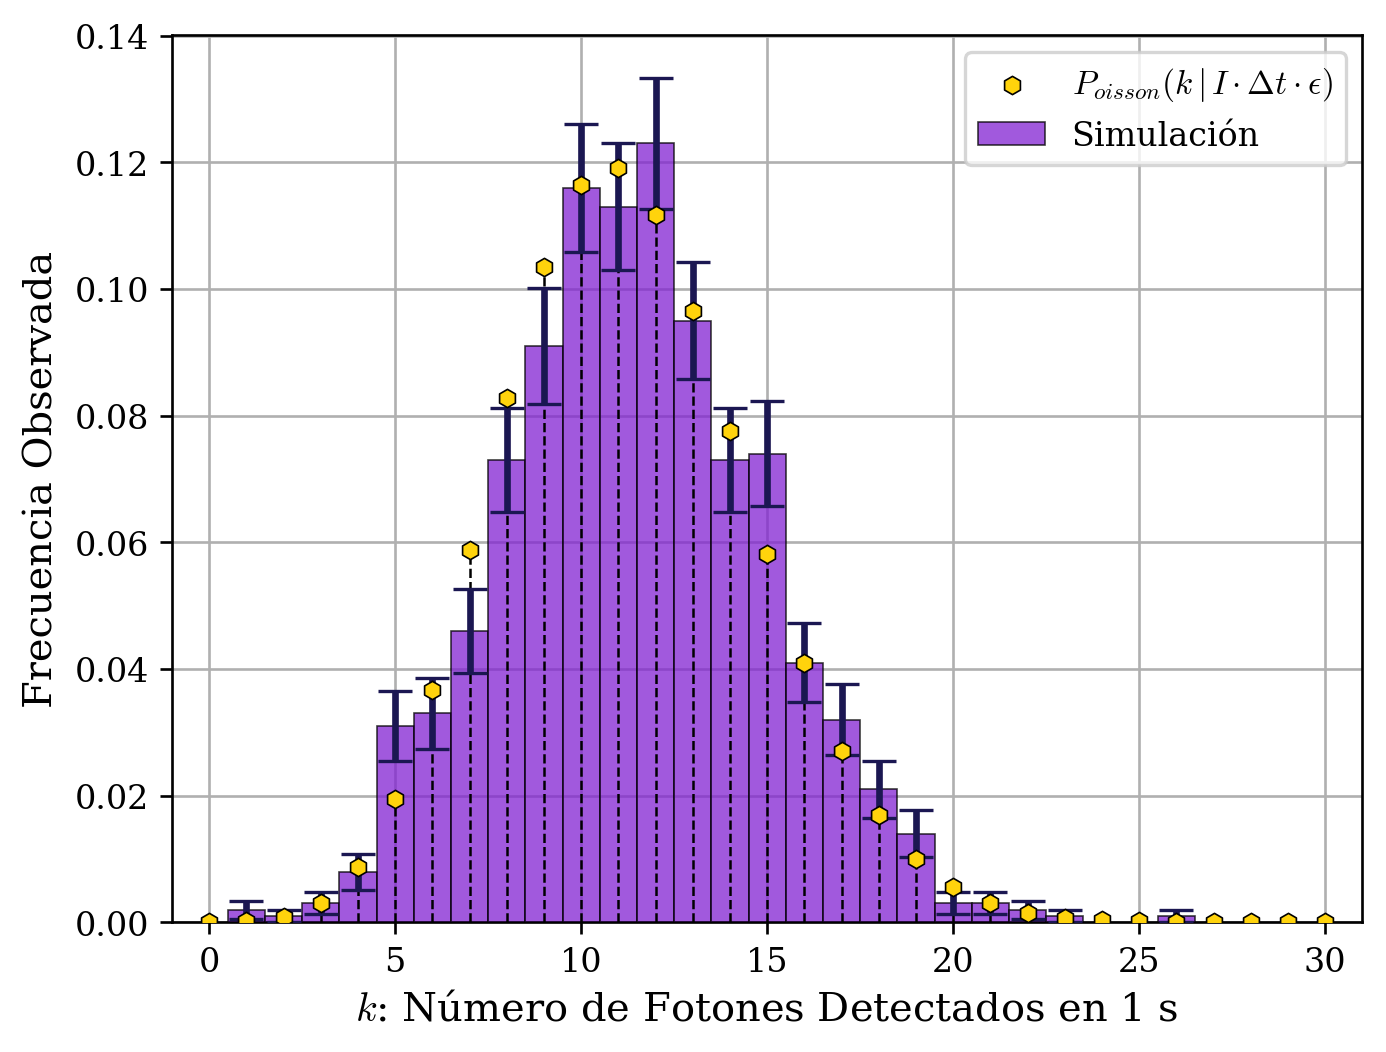

In [8]:
# Detectando los Fotones Emitidos:
fotones_detectados = np.empty_like(emitidos_por_segundo)
for experimento in range(N_experimentos):
    fotones_detectados[experimento] = simular_experimentos_bernoulli(
        emitidos_por_segundo[experimento], eficiencia
    )
# Cálculo de la distribución teorica de Poisson para dicho proceso:
valores_a_evaluar = np.arange(fotones_detectados.max() + 5)
poisson_esperada = poisson.pmf(
    valores_a_evaluar, duracion_experimento * intensidad_media * eficiencia
)
# Grafico de los resultados:
fig, ax = plt.subplots(1, 1)
plot_discrete_hist(
    fotones_detectados,
    label="Simulación",
    zorder=10,
    ax=ax,
)
plot_discrete_stem(
    valores_a_evaluar,
    poisson_esperada,
    label=r"$P_{oisson}\left(k\,|\,I\cdot\Delta{t}\cdot\epsilon\right)$",
    zorder=11,
    ax=ax,
)
ax.grid()
ax.legend()
ax.set_xlabel(f"$k$: Número de Fotones Detectados en {duracion_experimento} s")
ax.set_ylabel("Frecuencia Observada")
ax.set_xlim(-1, valores_a_evaluar.max() + 1)
plt.show()

En este caso el número de fotones detectados en cada segundo es como máximo el número de fotones emitidos en ese dado segundo (ya no tienen por qué ser 15). De esta manera, como el número de experimentos de Bernoulli por segundo no está definido, no es posible proponer una distribución binomial para el número de fotones observados en un segundo.

Sin embargo, resulta razonable que si en un experimento de un segundo la fuente emite en promedio $I\cdot\Delta t = 15$ fotones entonces se esperan detectar $15\cdot75\% = 11,\!25$ fotones considerando la eficiencia del sensor. Dicho esto, a fines prácticos y del modelado, la situación es equivalente a aquella en la que la fuente emite con una intensidad media de $11,\!25\:\mathrm{s}^{-1}$ y se tiene un detector de eficiencia del $100\%$, por lo que es posible proponer una distribución de Poisson para el número de fotones detectados en un segundo tal y como se muestra en la Figura.

## 5. Probabilidad Efectiva

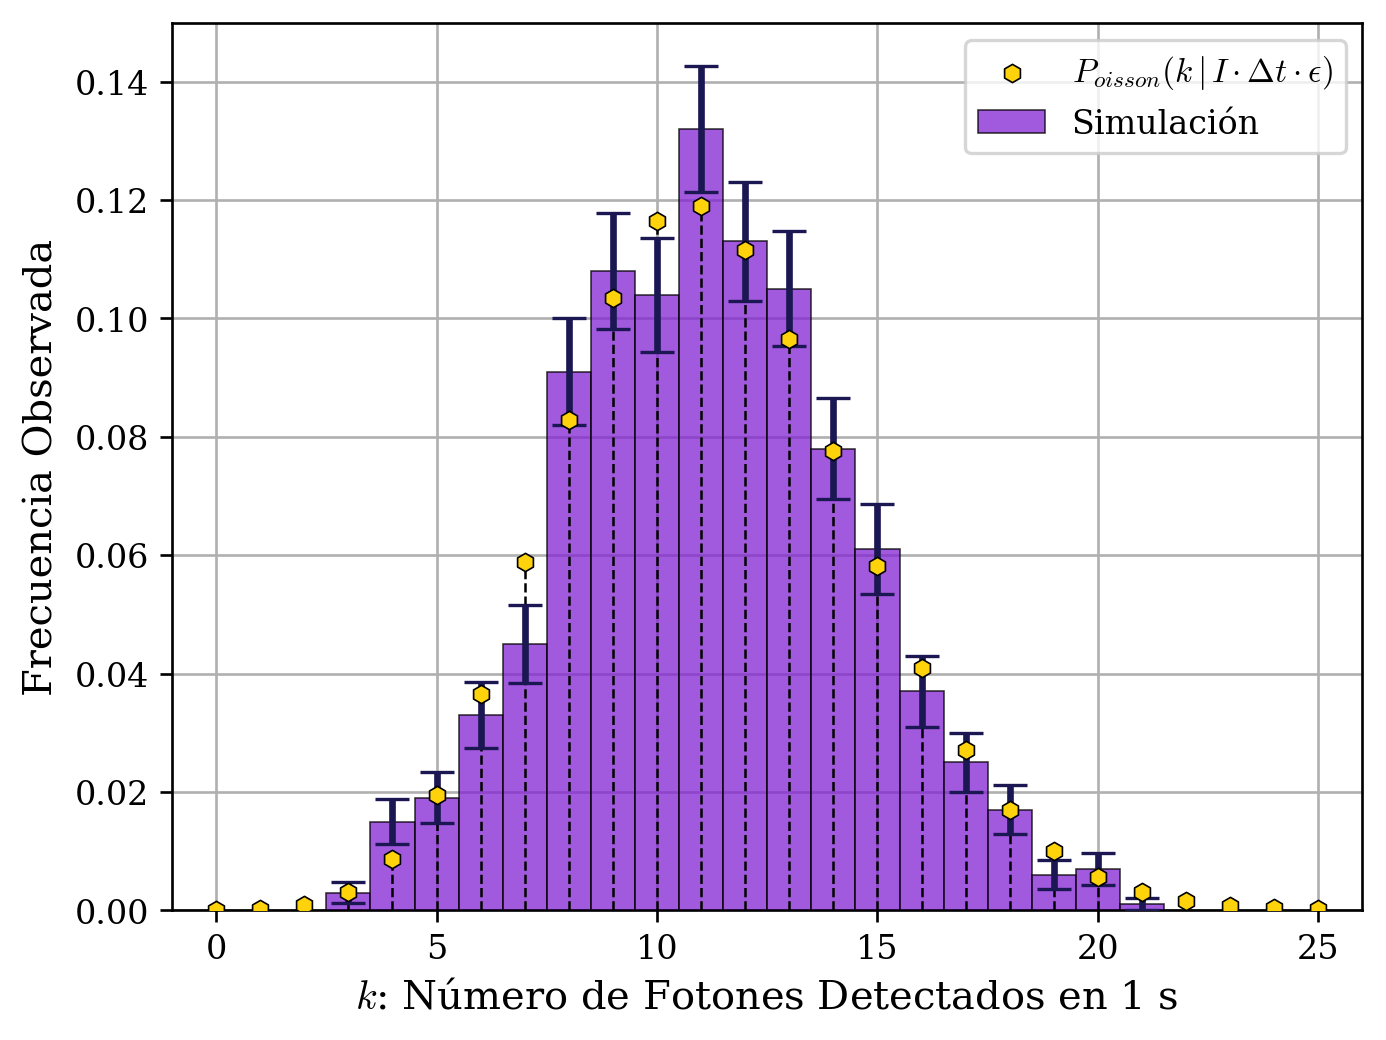

In [9]:
# Simulación de 1_000 experimentos compuestos: (emisión & detección)
N_experimentos = 1_000
probabilidad_efectiva = probabilidad_de_emision * eficiencia
fotones_detectados = np.empty(N_experimentos, dtype=int)
for experimento in range(N_experimentos):
    fotones_detectados[experimento] = simular_experimentos_bernoulli(
        subdivisiones, probabilidad_efectiva
    )

valores_a_evaluar = np.arange(fotones_detectados.max() + 5)
distribucion_esperada = poisson.pmf(
    valores_a_evaluar, duracion_experimento * intensidad_media * eficiencia
)
fig, ax = plt.subplots(1, 1)
plot_discrete_hist(
    fotones_detectados,
    label="Simulación",
    zorder=10,
    ax=ax,
)
plot_discrete_stem(
    valores_a_evaluar,
    distribucion_esperada,
    label=r"$P_{oisson}\left(k\,|\,I\cdot\Delta{t}\cdot\epsilon\right)$",
    zorder=11,
    ax=ax,
)
ax.legend()
ax.grid()
ax.set_xlabel(f"$k$: Número de Fotones Detectados en {duracion_experimento} s")
ax.set_ylabel("Frecuencia Observada")
ax.set_xlim(-1, valores_a_evaluar.max() + 1)
plt.show()

## 6. Distribución del Número de Cuentas por _bin_